### Gathering the data from the tables stored on snowflake

In [50]:
import os
from dotenv import load_dotenv
import snowflake.connector
import pandas as pd
from pathlib import Path
env_path = Path('.') / 'environment.env'
load_dotenv(dotenv_path=env_path)

SF_USER = os.getenv("SF_USER")
SF_PASSWORD = os.getenv("SF_PASSWORD")
SF_ACCOUNT = os.getenv("SF_ACCOUNT")
SF_WAREHOUSE = os.getenv("SF_WAREHOUSE")
SF_DATABASE = os.getenv("SF_DATABASE")
SF_SCHEMA = os.getenv("SF_SCHEMA")

# Conexão com Snowflake
conn = snowflake.connector.connect(
    user=SF_USER,
    password=SF_PASSWORD,
    account=SF_ACCOUNT,
    warehouse=SF_WAREHOUSE,
    database=SF_DATABASE,
    schema=SF_SCHEMA
)

# ============================
# Consultas
# ============================
df_customers = pd.read_sql("SELECT * FROM customers_refined", conn)
df_orders = pd.read_sql("SELECT * FROM orders_refined", conn)
df_payments = pd.read_sql("SELECT * FROM order_payments_refined", conn)

# Fecha conexão
conn.close()

# ============================
# Padroniza nomes de colunas
# ============================
for df in [df_customers, df_orders, df_payments]:
    df.columns = df.columns.str.lower()

# ============================
# Função para converter timestamp
# ============================
def safe_timestamp_to_datetime(series):
    series = pd.to_numeric(series, errors='coerce')
    if series.dropna().empty:
        return pd.NaT
    max_val = series.max()
    if max_val > 1e18:           # nanosegundos
        unit = 'ns'
    elif max_val > 1e12:         # milissegundos
        unit = 'ms'
    else:                        # segundos
        unit = 's'
    return pd.to_datetime(series, unit=unit, errors='coerce')

# Converte timestamps em orders
if 'order_purchase_timestamp' in df_orders.columns:
    df_orders['order_purchase_datetime'] = safe_timestamp_to_datetime(df_orders['order_purchase_timestamp'])

# ============================
# Merge Orders + Customers
# ============================
df_orders_customers = df_orders.merge(
    df_customers[['customer_id', 'customer_city', 'customer_state', 'customer_zip_code_prefix']],
    on='customer_id',
    how='left'
)

print("Orders + Customers:")
print(df_orders_customers.head())
print(f"Total registros: {len(df_orders_customers)}")


C:\Users\pacie\AppData\Local\Temp\ipykernel_23460\3825293523.py:29: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_customers = pd.read_sql("SELECT * FROM customers_refined", conn)
C:\Users\pacie\AppData\Local\Temp\ipykernel_23460\3825293523.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_orders = pd.read_sql("SELECT * FROM orders_refined", conn)
C:\Users\pacie\AppData\Local\Temp\ipykernel_23460\3825293523.py:31: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_payments = pd.read_sql("SELECT * FROM order_payments_r

Orders + Customers:
                           order_id                       customer_id  \
0  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
1  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
2  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  85ce859fd6dc634de8d2f1e290444043  059f7fc5719c7da6cbafe370971a8d70   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      1511033286000000000  1511034359000000000   
1    delivered      1511033286000000000  1511034359000000000   
2    delivered      1511033286000000000  1511034359000000000   
3    delivered      1511033286000000000  1511034359000000000   
4    delivered      1511222621000000000  1511223262000000000   

  order_delivered_carrier_date order_delivered_customer_date  \
0          1511357999000000000           1512174522000000000   
1          15113579990000000

### Analise bivariada de Orders x Customers x Order_payment


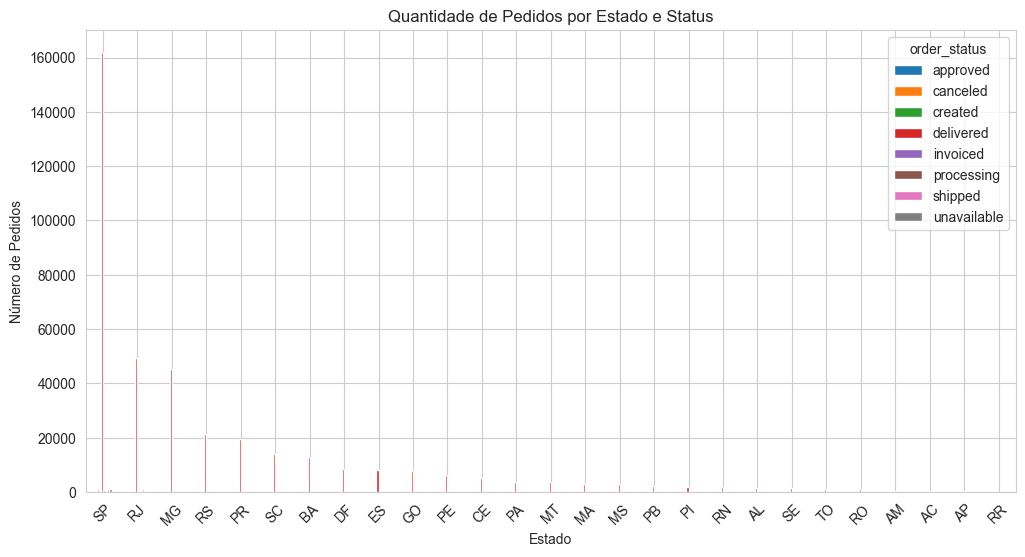

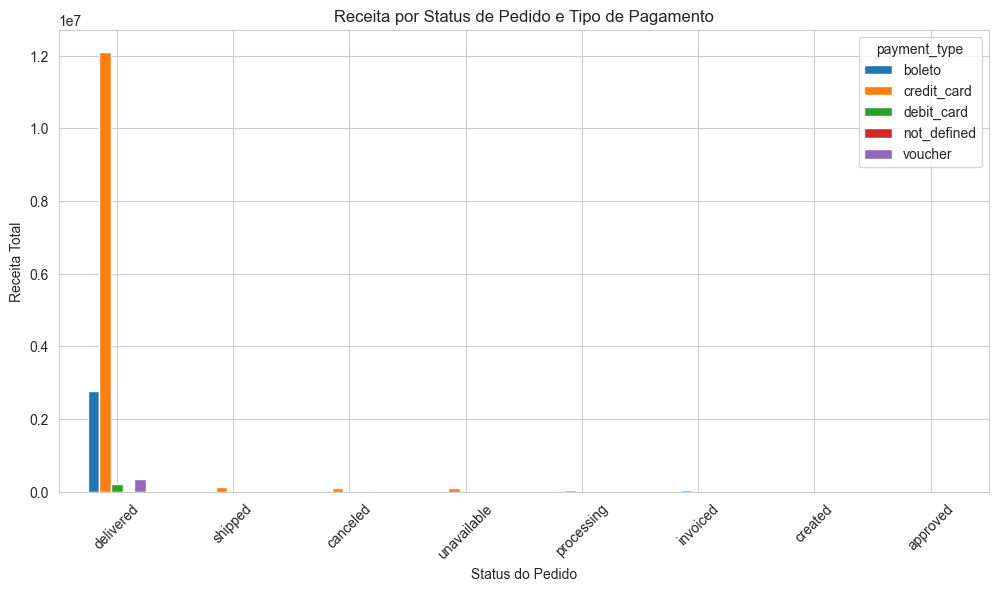

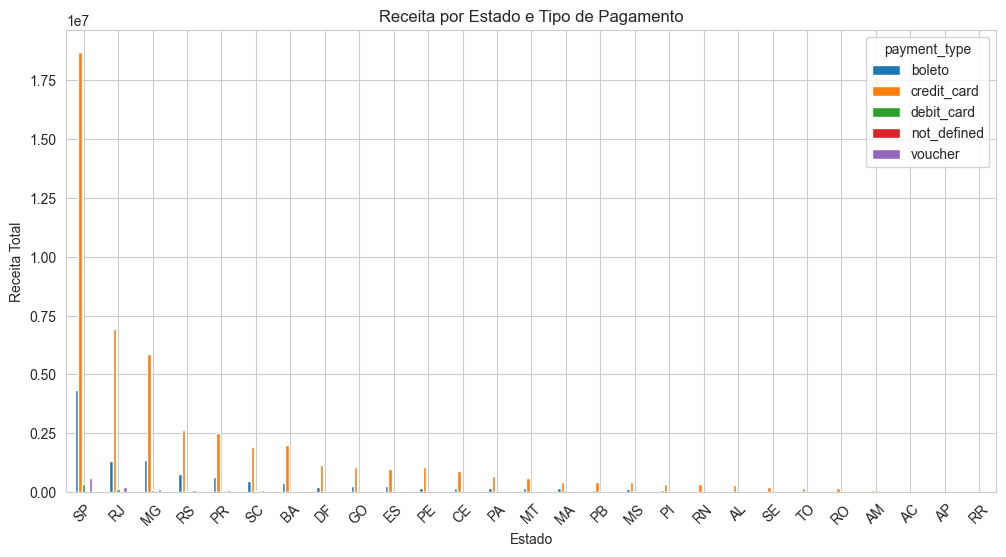

In [51]:
import matplotlib.pyplot as plt
#import pandas as pd

# Função para plotar gráfico simples (uma barra por categoria)
def plot_simple_bar(pivot_df, title, xlabel, ylabel):
    pivot_df.plot(kind='bar', figsize=(12,6))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.legend(title=pivot_df.columns.name)
    plt.show()

# --- 1. Customers × Orders (quantidade de pedidos por estado e status) ---
cust_orders_counts = df_orders_customers.groupby(['customer_state', 'order_status']).size().reset_index(name='count')
pivot_cust_orders = cust_orders_counts.pivot(index='customer_state', columns='order_status', values='count').fillna(0)
pivot_cust_orders = pivot_cust_orders.loc[pivot_cust_orders.sum(axis=1).sort_values(ascending=False).index]
plot_simple_bar(pivot_cust_orders, 'Quantidade de Pedidos por Estado e Status', 'Estado', 'Número de Pedidos')

# --- 2. Orders × Order Payments (receita por status do pedido e tipo de pagamento) ---
df_orders_payments = df_orders.merge(df_payments, on='order_id', how='left')
df_orders_payments['payment_value'] = pd.to_numeric(df_orders_payments['payment_value'], errors='coerce').fillna(0)

orders_payments_rev = df_orders_payments.groupby(['order_status', 'payment_type'])['payment_value'].sum().reset_index()
pivot_orders_payments = orders_payments_rev.pivot(index='order_status', columns='payment_type', values='payment_value').fillna(0)
pivot_orders_payments = pivot_orders_payments.loc[pivot_orders_payments.sum(axis=1).sort_values(ascending=False).index]
plot_simple_bar(pivot_orders_payments, 'Receita por Status de Pedido e Tipo de Pagamento', 'Status do Pedido', 'Receita Total')

# --- 3. Customers × Order Payments (receita por estado e tipo de pagamento) ---
df_cust_payments = df_orders_payments.merge(df_customers[['customer_id', 'customer_state']], on='customer_id', how='left')
cust_payments_rev = df_cust_payments.groupby(['customer_state', 'payment_type'])['payment_value'].sum().reset_index()
pivot_cust_payments = cust_payments_rev.pivot(index='customer_state', columns='payment_type', values='payment_value').fillna(0)
pivot_cust_payments = pivot_cust_payments.apply(pd.to_numeric, errors='coerce').fillna(0)
pivot_cust_payments = pivot_cust_payments.loc[pivot_cust_payments.sum(axis=1).sort_values(ascending=False).index]
plot_simple_bar(pivot_cust_payments, 'Receita por Estado e Tipo de Pagamento', 'Estado', 'Receita Total')


### Top 10 de categorias de `customers_refined`
#### Analise univariada de customers_refined (está com um problema de não mostrar os dados, resolvo depois)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# ============================
# Separar variáveis numéricas e categóricas
# ============================
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

# Se o zip code estiver como numérico, tratamos como string
if 'customer_zip_code_prefix' in num_cols:
    df['customer_zip_code_prefix'] = df['customer_zip_code_prefix'].astype(str)
    num_cols.remove('customer_zip_code_prefix')
    cat_cols.append('customer_zip_code_prefix')

print("Variáveis numéricas:", num_cols)
print("Variáveis categóricas:", cat_cols)

# ============================
# 1. Análise univariada - Zip Code Prefix (agora categórico)
# ============================
if 'customer_zip_code_prefix' in cat_cols:
    top_zips = df['customer_zip_code_prefix'].value_counts().head(10)
    plt.figure(figsize=(10,5))
    sns.barplot(x=top_zips.values, y=top_zips.index, palette="coolwarm")
    plt.title("Top 10 CEPs mais frequentes")
    plt.xlabel("Quantidade de Clientes")
    plt.ylabel("CEP Prefixo")
    plt.show()

# ============================
# 2. Análise univariada - Cidades
# ============================
if 'customer_city' in cat_cols:
    top_cities = df['customer_city'].value_counts().head(10)
    plt.figure(figsize=(10,5))
    sns.barplot(x=top_cities.values, y=top_cities.index, palette="viridis")
    plt.title("Top 10 Cidades com Mais Pedidos")
    plt.xlabel("Quantidade de Clientes")
    plt.ylabel("Cidade")
    plt.show()

# ============================
# 3. Análise univariada - Estados
# ============================
if 'customer_state' in cat_cols:
    top_states = df['customer_state'].value_counts()
    plt.figure(figsize=(10,5))
    sns.barplot(x=top_states.values, y=top_states.index, palette="magma")
    plt.title("Clientes por Estado")
    plt.xlabel("Quantidade de Clientes")
    plt.ylabel("Estado")
    plt.show()


# ============================
# 4. Proporção de clientes por estado
# ============================
if 'customer_state' in cat_cols:
    state_counts = df['customer_state'].value_counts()
    state_percent = (state_counts / state_counts.sum()) * 100

    # DataFrame para visualização
    state_df = pd.DataFrame({
        'Estado': state_counts.index,
        'Clientes': state_counts.values,
        'Percentual (%)': state_percent.values
    })

    # Ordenar por percentual
    state_df = state_df.sort_values(by='Percentual (%)', ascending=False)

    # Exibir tabela
    print("\n📊 Proporção de clientes por estado:")
    print(state_df.to_string(index=False, formatters={'Percentual (%)': '{:.2f}'.format}))

    # Gráfico de pizza
    plt.figure(figsize=(8,8))
    plt.pie(
        state_df['Clientes'],
        labels=state_df['Estado'],
        autopct='%1.1f%%',
        startangle=90,
        colors=sns.color_palette("pastel", len(state_df))
    )
    plt.title("Proporção de Clientes por Estado")
    plt.axis('equal')  # garante que o gráfico seja um círculo
    plt.show()


Variáveis numéricas: []
Variáveis categóricas: ['order_id', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value', 'installment_category', 'is_high_value_payment']


### Analise univariada de Orders_refined com gráficos

In [42]:
# Separar variáveis numéricas e categóricas
num_cols = df_orders.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = df_orders.select_dtypes(include=['object']).columns.tolist()

# Se tiver timestamps convertidos para datetime, removemos de numéricas
if 'order_purchase_datetime' in num_cols:
    num_cols.remove('order_purchase_datetime')

# Visualizar colunas
print("Variáveis numéricas:", num_cols)
print("Variáveis categóricas:", cat_cols)


Variáveis numéricas: []
Variáveis categóricas: ['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'approval_time_hours', 'processing_time_hours', 'shipping_time_hours', 'total_delivery_time_hours', 'delivery_delay_hours', 'delivery_performance', 'purchase_hour', 'purchase_day_of_week']


### Top 10 de cada coluna do Orders_payment

C:\Users\pacie\AppData\Local\Temp\ipykernel_23460\2088036696.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_values.values, y=top_values.index, palette="coolwarm")


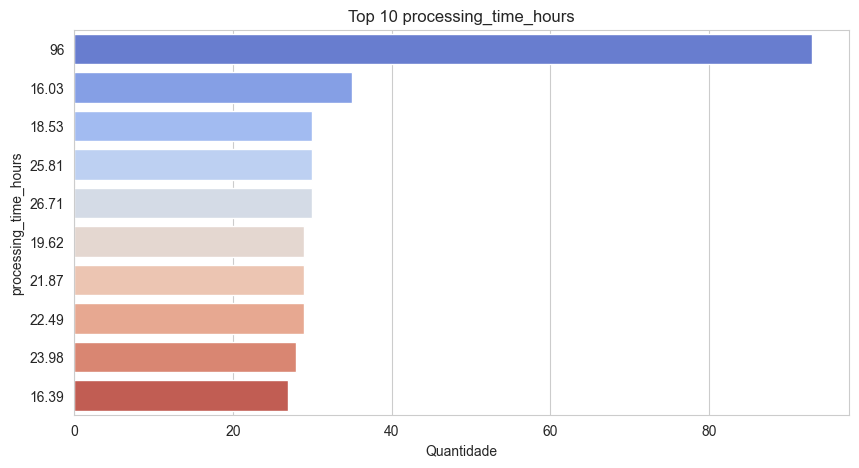

C:\Users\pacie\AppData\Local\Temp\ipykernel_23460\2088036696.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_values.values, y=top_values.index, palette="coolwarm")


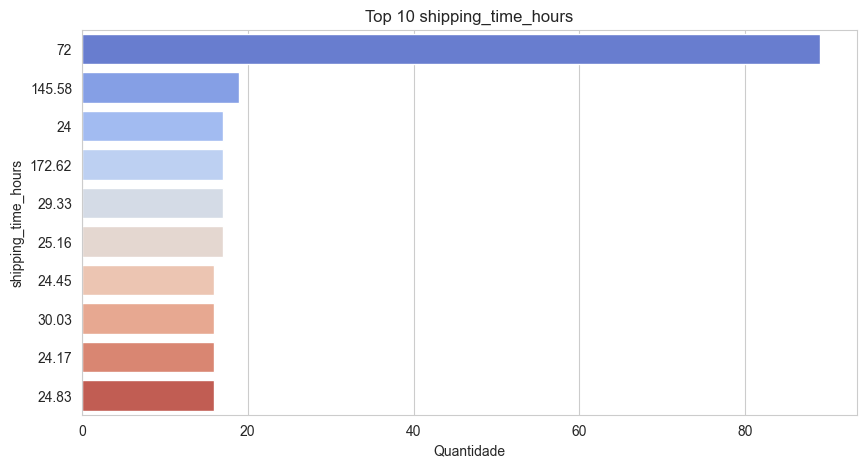

C:\Users\pacie\AppData\Local\Temp\ipykernel_23460\2088036696.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_values.values, y=top_values.index, palette="coolwarm")


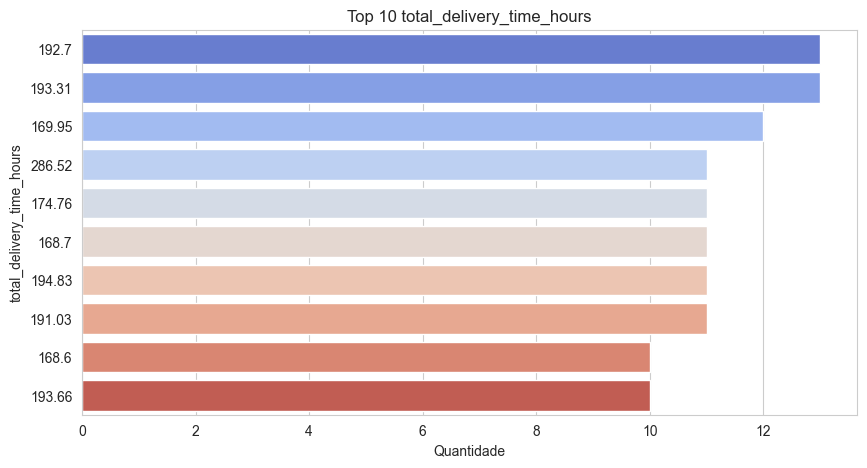

C:\Users\pacie\AppData\Local\Temp\ipykernel_23460\2088036696.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_values.values, y=top_values.index, palette="coolwarm")


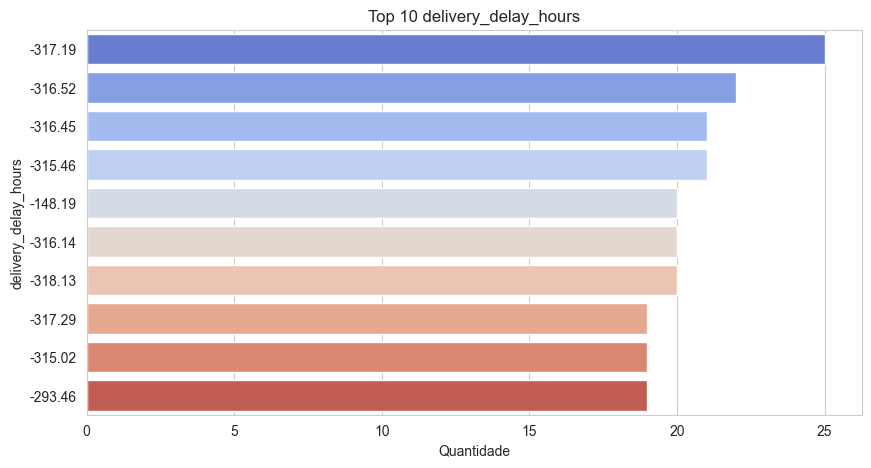

C:\Users\pacie\AppData\Local\Temp\ipykernel_23460\2088036696.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_values.values, y=top_values.index, palette="coolwarm")


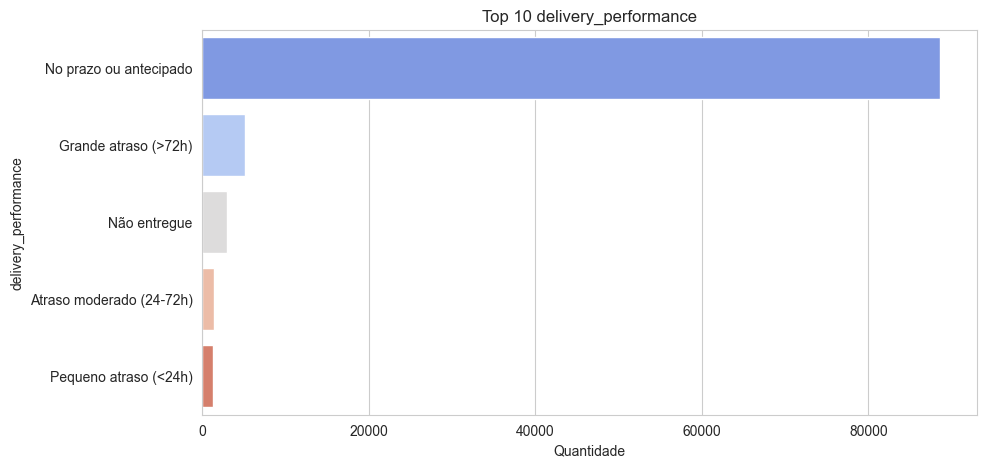

C:\Users\pacie\AppData\Local\Temp\ipykernel_23460\2088036696.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_values.values, y=top_values.index, palette="coolwarm")


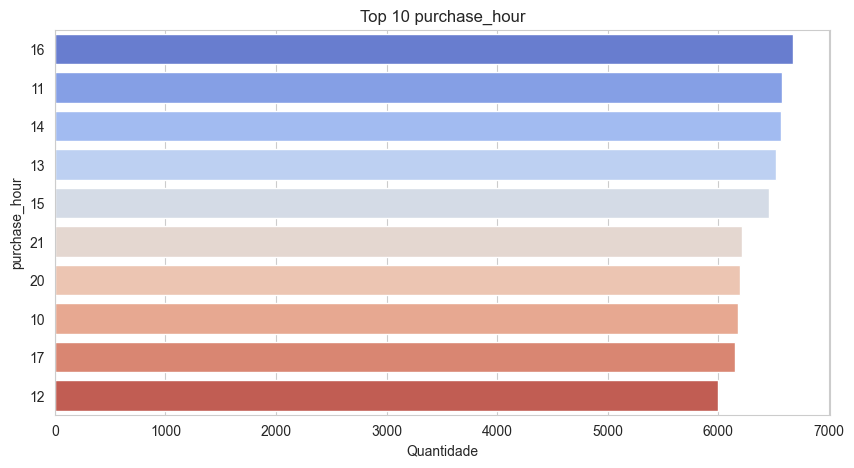

C:\Users\pacie\AppData\Local\Temp\ipykernel_23460\2088036696.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_values.values, y=top_values.index, palette="coolwarm")


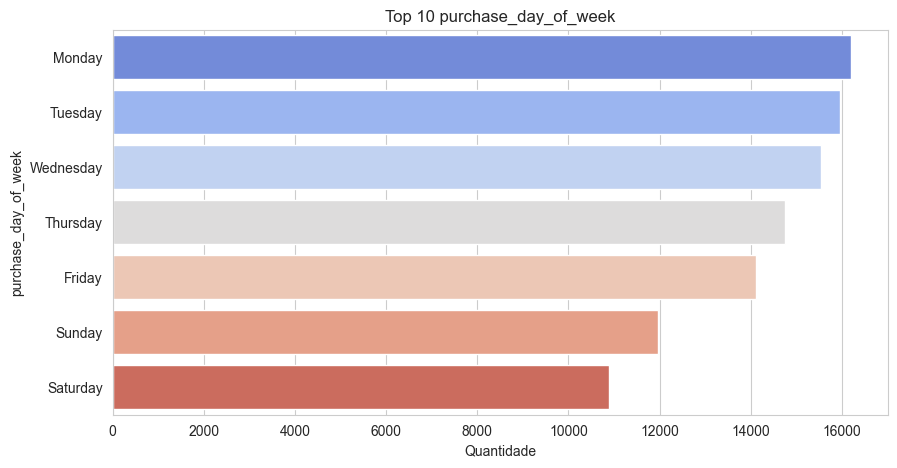

In [43]:
# numericas e categoricas

import matplotlib.pyplot as plt
import seaborn as sns

for col in cat_cols[-7:]:
    top_values = df_orders[col].value_counts().head(10)
    plt.figure(figsize=(10,5))
    sns.barplot(x=top_values.values, y=top_values.index, palette="coolwarm")
    plt.title(f"Top 10 {col}")
    plt.xlabel("Quantidade")
    plt.ylabel(col)
    plt.show()


### Utilizando o Gemini Pro para gerar insights e gráficos a partir daqui
#### Os dados analisados ainda foram os de orders, customers, e order_payments

📊 Gerando gráfico de volume de pedidos por mês...


C:\Users\pacie\AppData\Local\Temp\ipykernel_23460\1741581987.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_orders = df_orders_customers.set_index('order_purchase_datetime').resample('M').size()


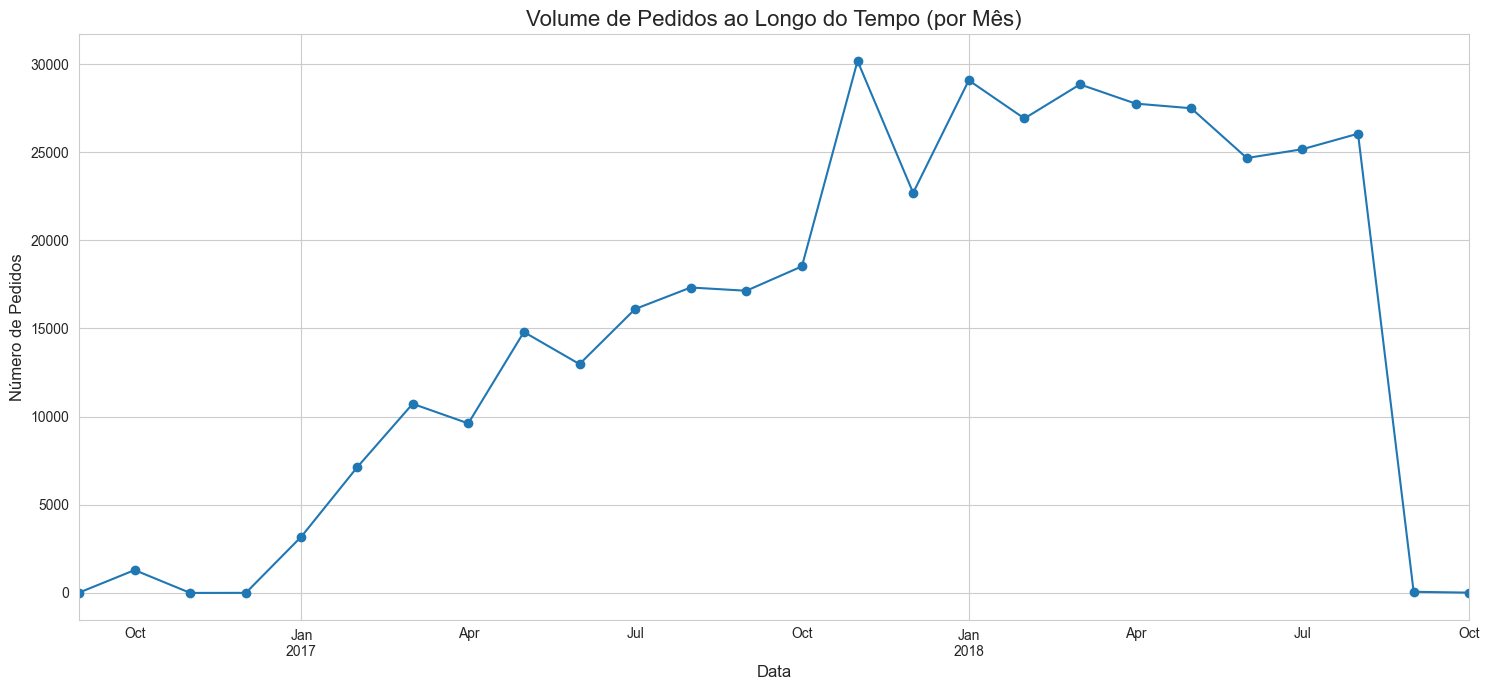

In [28]:
#import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configuração visual dos gráficos
sns.set_style("whitegrid")

# --- 1. Análise de Séries Temporais: Volume de Pedidos por Mês ---
print("📊 Gerando gráfico de volume de pedidos por mês...")

# Garante que a coluna de data é do tipo datetime
if 'order_purchase_datetime' in df_orders_customers.columns:
    # Agrupa por mês e conta o número de pedidos
    monthly_orders = df_orders_customers.set_index('order_purchase_datetime').resample('M').size()

    plt.figure(figsize=(15, 7))
    monthly_orders.plot(kind='line', marker='o')
    plt.title('Volume de Pedidos ao Longo do Tempo (por Mês)', fontsize=16)
    plt.xlabel('Data', fontsize=12)
    plt.ylabel('Número de Pedidos', fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('monthly_orders_volume.png')
    plt.show()
else:
    print("A coluna 'order_purchase_datetime' não foi encontrada. Verifique o seu código.")


💰 Gerando gráfico de valor médio de pagamento por tipo...


C:\Users\pacie\AppData\Local\Temp\ipykernel_23460\3685889900.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_payment_value.index, y=avg_payment_value.values, palette="viridis")


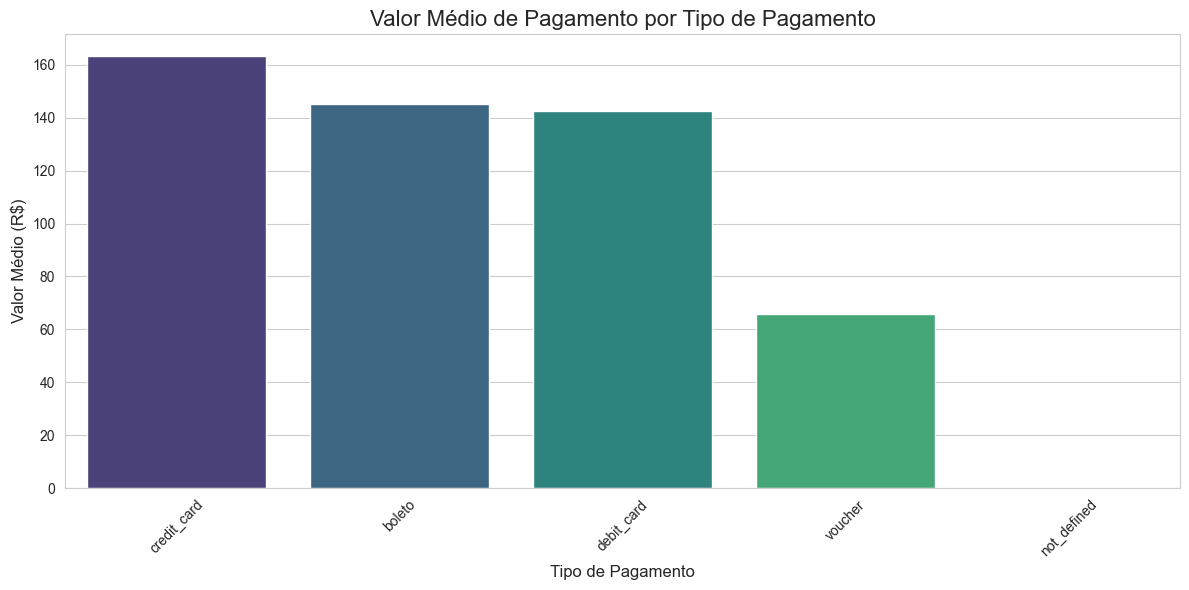

In [29]:
# --- 2. Valor Médio de Pagamento por Tipo de Pagamento ---
print("\n💰 Gerando gráfico de valor médio de pagamento por tipo...")

# Remove valores nulos da coluna de pagamento
df_orders_payments_cleaned = df_orders_payments.dropna(subset=['payment_value'])

# Agrupa por tipo de pagamento e calcula a média
avg_payment_value = df_orders_payments_cleaned.groupby('payment_type')['payment_value'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=avg_payment_value.index, y=avg_payment_value.values, palette="viridis")
plt.title('Valor Médio de Pagamento por Tipo de Pagamento', fontsize=16)
plt.xlabel('Tipo de Pagamento', fontsize=12)
plt.ylabel('Valor Médio (R$)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('avg_payment_value_by_type.png')
plt.show()


📦 Gerando box plot de atraso de entrega por estado (versão melhorada)...


C:\Users\pacie\AppData\Local\Temp\ipykernel_23460\3990547786.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='customer_state', y='delivery_delay_hours', data=df_top_states_filtered, palette='magma')


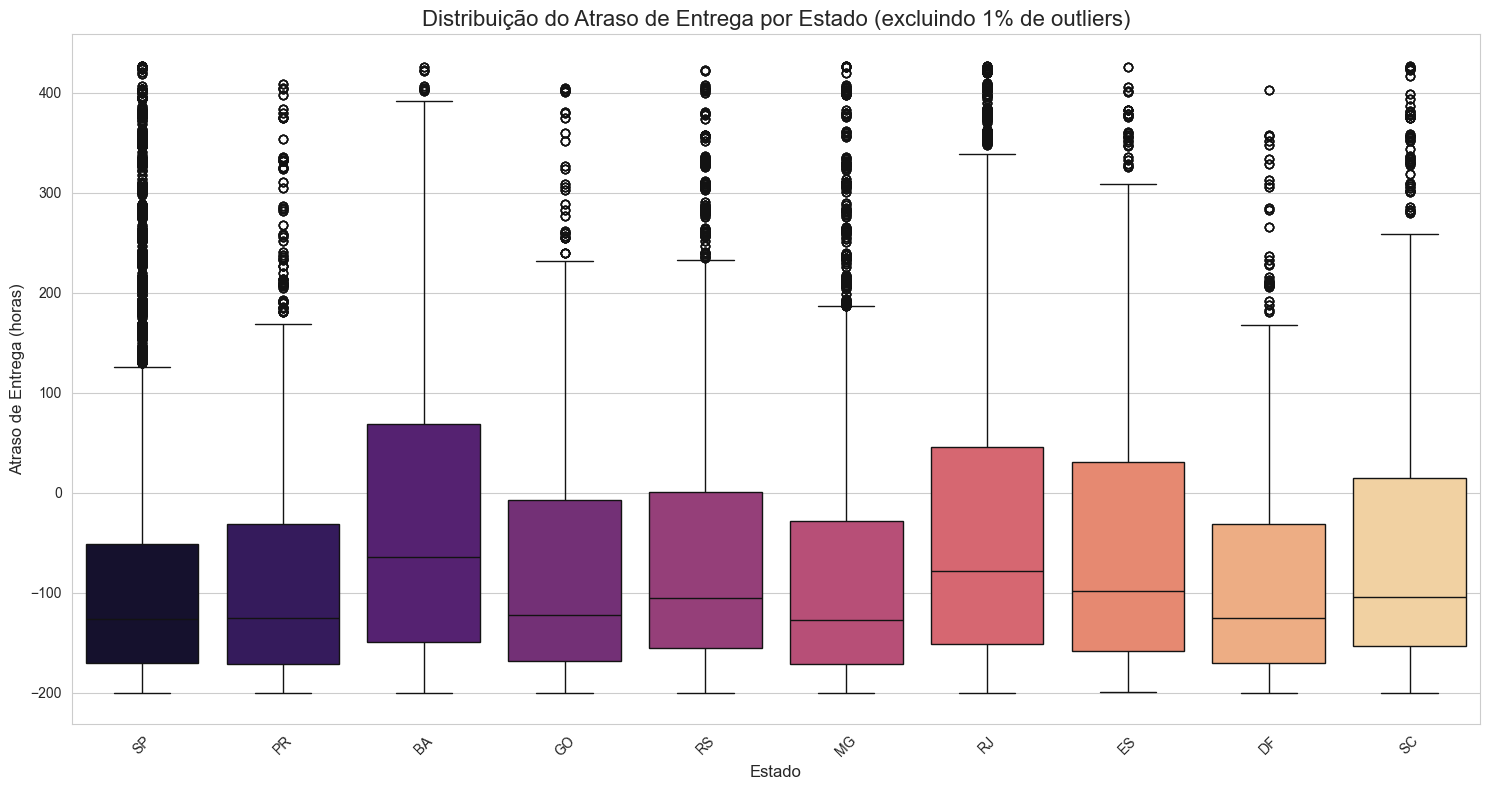

Insights: O novo gráfico agora foca na variação típica do atraso de entrega para cada estado. Você pode comparar a mediana (linha no meio da caixa) e a dispersão dos dados para entender onde as entregas são mais consistentes ou menos atrasadas. O novo filtro torna a visualização muito mais útil para a tomada de decisões logísticas.


In [40]:
# --- 3. Análise de Desempenho de Entrega por Estado (CORRIGIDO) ---
print("\n📦 Gerando box plot de atraso de entrega por estado (versão melhorada)...")

# Identifica os top 10 estados com mais pedidos
top_states = df_orders_customers['customer_state'].value_counts().nlargest(10).index

# Filtra o DataFrame para incluir apenas os top 10 estados
df_top_states = df_orders_customers[df_orders_customers['customer_state'].isin(top_states)].copy()

# 💡 A CORREÇÃO ESTÁ AQUI: Garante que a coluna de atraso é numérica
df_top_states['delivery_delay_hours'] = pd.to_numeric(df_top_states['delivery_delay_hours'], errors='coerce')
df_top_states.dropna(subset=['delivery_delay_hours'], inplace=True)

# 💡 MELHORIA: Filtra os outliers extremos na coluna 'delivery_delay_hours'
# Mantemos apenas 99% dos dados com o menor atraso.
delay_threshold = df_top_states['delivery_delay_hours'].quantile(0.99)
df_top_states_filtered = df_top_states[df_top_states['delivery_delay_hours'] <= delay_threshold]

# Também removemos atrasos muito negativos (entregas impossivelmente rápidas)
df_top_states_filtered = df_top_states_filtered[df_top_states_filtered['delivery_delay_hours'] >= -200]

plt.figure(figsize=(15, 8))
sns.boxplot(x='customer_state', y='delivery_delay_hours', data=df_top_states_filtered, palette='magma')
plt.title('Distribuição do Atraso de Entrega por Estado (excluindo 1% de outliers)', fontsize=16)
plt.xlabel('Estado', fontsize=12)
plt.ylabel('Atraso de Entrega (horas)', fontsize=12)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print("Insights: O novo gráfico agora foca na variação típica do atraso de entrega para cada estado. Você pode comparar a mediana (linha no meio da caixa) e a dispersão dos dados para entender onde as entregas são mais consistentes ou menos atrasadas. O novo filtro torna a visualização muito mais útil para a tomada de decisões logísticas.")

### Gemini Pro analisando também com os dados de order_reviews e order_items

#### Análise de Desempenho de Produtos e Avaliações
Esta análise conecta o desempenho de vendas (quantidade de itens vendidos) com a satisfação do cliente (nota da avaliação). O objetivo é identificar os produtos mais vendidos e entender se eles mantêm uma alta nota de avaliação.

🔌 Conectando ao Snowflake para carregar order_items e orders_reviews...


C:\Users\pacie\AppData\Local\Temp\ipykernel_23460\716468206.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_order_items = pd.read_sql("SELECT * FROM order_items_refined", conn)
C:\Users\pacie\AppData\Local\Temp\ipykernel_23460\716468206.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_orders_reviews = pd.read_sql("SELECT * FROM order_reviews_refined", conn)
C:\Users\pacie\AppData\Local\Temp\ipykernel_23460\716468206.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_review_by_product.index, y=avg_review_by_

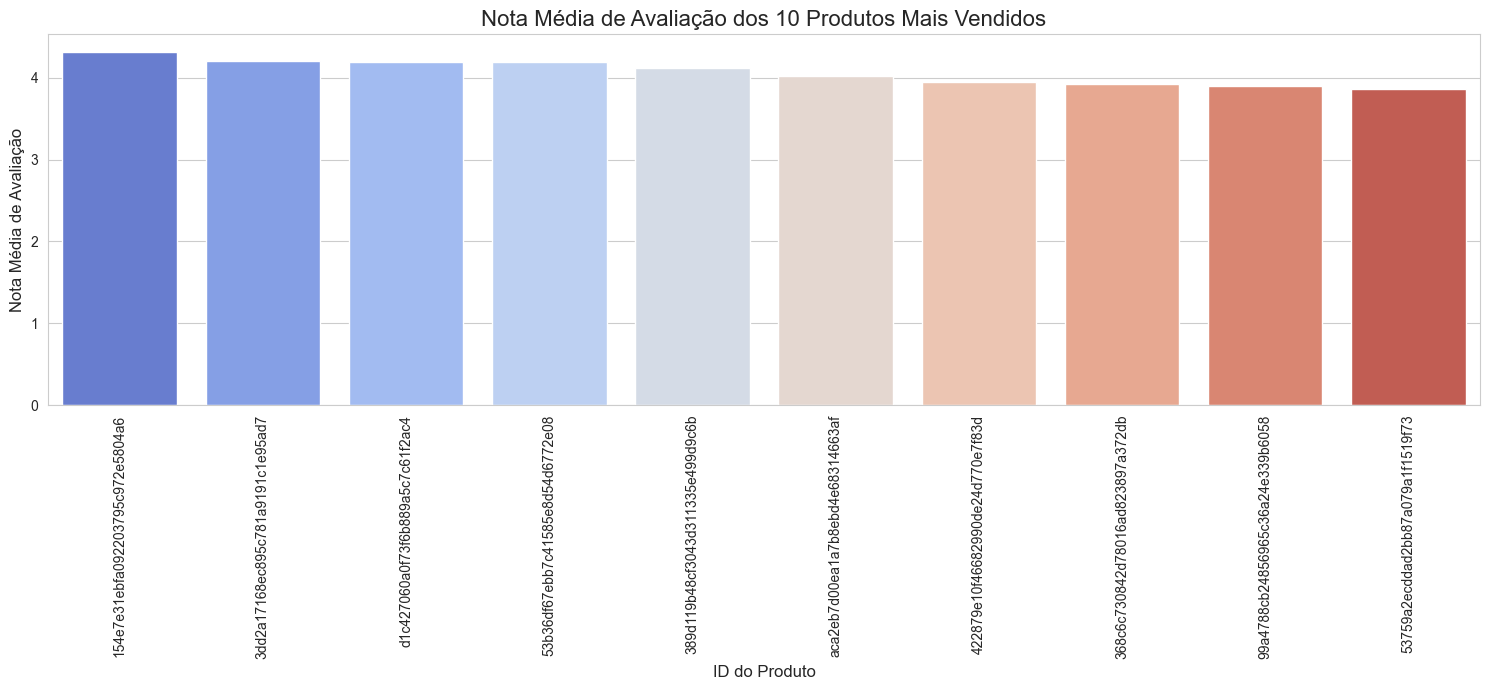

Insights: Este gráfico mostra se os produtos mais populares também são bem avaliados. Uma nota baixa para um produto popular pode indicar um problema de qualidade ou de expectativa do cliente.


In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Requisitando dados das novas tabelas
print("🔌 Conectando ao Snowflake para carregar order_items e orders_reviews...")
conn = snowflake.connector.connect(
    user=SF_USER,
    password=SF_PASSWORD,
    account=SF_ACCOUNT,
    warehouse=SF_WAREHOUSE,
    database=SF_DATABASE,
    schema=SF_SCHEMA
)

df_order_items = pd.read_sql("SELECT * FROM order_items_refined", conn)
df_orders_reviews = pd.read_sql("SELECT * FROM order_reviews_refined", conn)
conn.close()

# Padroniza nomes de colunas
df_order_items.columns = df_order_items.columns.str.lower()
df_orders_reviews.columns = df_orders_reviews.columns.str.lower()

# --- Unindo as tabelas para a análise ---
# Junta orders_reviews e orders
df_orders_and_reviews = df_orders.merge(df_orders_reviews, on='order_id', how='left')

# Junta com order_items para obter os produtos
df_products_reviews = df_orders_and_reviews.merge(df_order_items[['order_id', 'product_id']], on='order_id', how='left')

# --- Calculando e Visualizando ---
# Remove nulos e converte a nota para numérico
df_products_reviews['review_score'] = pd.to_numeric(df_products_reviews['review_score'], errors='coerce')
df_products_reviews.dropna(subset=['product_id', 'review_score'], inplace=True)

# Encontra os 10 produtos mais vendidos
top_products_id = df_products_reviews['product_id'].value_counts().nlargest(10).index

# Filtra o DataFrame para apenas esses produtos
df_top_products = df_products_reviews[df_products_reviews['product_id'].isin(top_products_id)]

# Calcula a nota média para cada produto
avg_review_by_product = df_top_products.groupby('product_id')['review_score'].mean().sort_values(ascending=False)

# Plota o gráfico
plt.figure(figsize=(15, 7))
sns.barplot(x=avg_review_by_product.index, y=avg_review_by_product.values, palette="coolwarm")
plt.title('Nota Média de Avaliação dos 10 Produtos Mais Vendidos', fontsize=16)
plt.xlabel('ID do Produto', fontsize=12)
plt.ylabel('Nota Média de Avaliação', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

print("Insights: Este gráfico mostra se os produtos mais populares também são bem avaliados. Uma nota baixa para um produto popular pode indicar um problema de qualidade ou de expectativa do cliente.")

### 2. Análise de Logística e Avaliações: Tempo de Entrega vs. Satisfação
Esta análise investiga se o tempo total de entrega (do pedido até o cliente) tem um impacto na nota de avaliação. Isso é crucial para entender a importância da logística na experiência do cliente.


📦 Gerando gráfico de tempo de entrega vs. satisfação do cliente...


C:\Users\pacie\AppData\Local\Temp\ipykernel_23460\2093095368.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


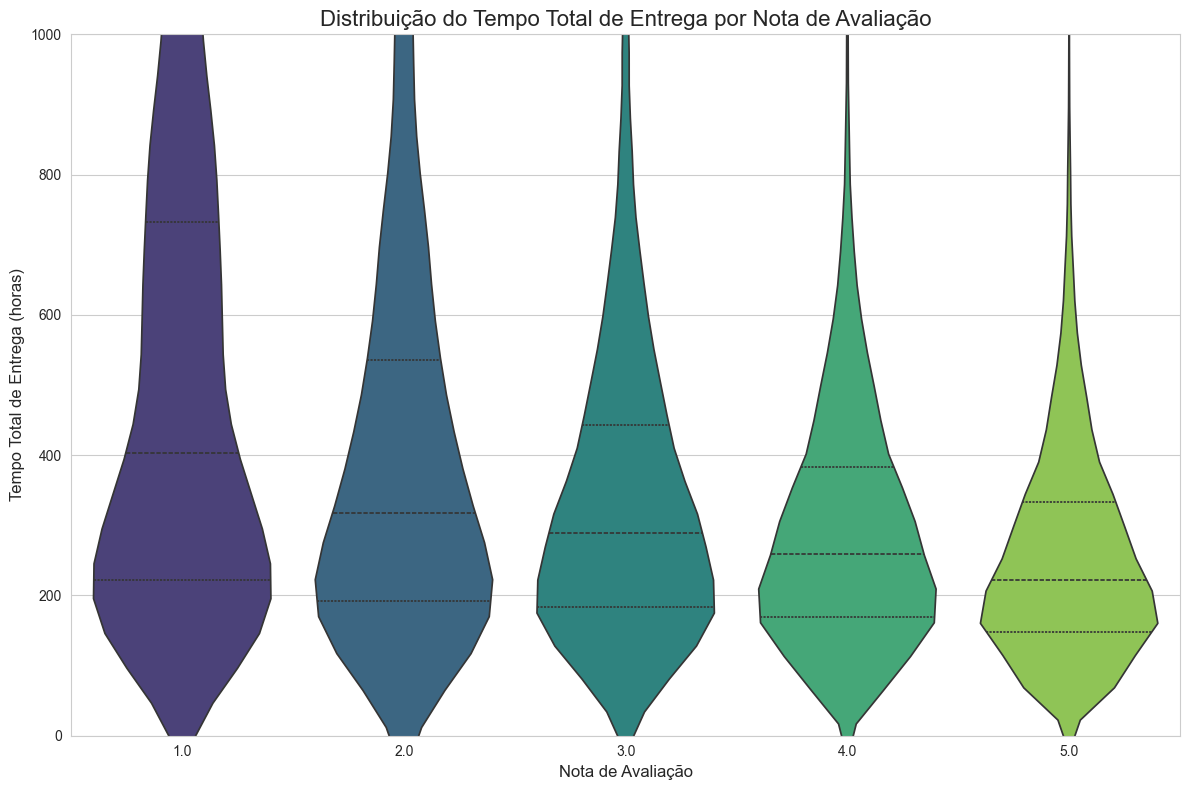

Insights: O gráfico de violino mostra a distribuição do tempo de entrega para cada nota. Por exemplo, você pode ver se a maioria dos pedidos com nota 1 teve um tempo de entrega muito mais longo do que os pedidos com nota 5.


In [33]:
# --- 2. Análise de Logística e Avaliações ---
print("\n📦 Gerando gráfico de tempo de entrega vs. satisfação do cliente...")

# Garantindo que as colunas de tempo e nota estão no formato correto
df_orders_and_reviews['total_delivery_time_hours'] = pd.to_numeric(df_orders_and_reviews['total_delivery_time_hours'], errors='coerce')
df_orders_and_reviews['review_score'] = pd.to_numeric(df_orders_and_reviews['review_score'], errors='coerce')

# Removendo dados com valores nulos
df_logistics_reviews = df_orders_and_reviews.dropna(subset=['review_score', 'total_delivery_time_hours'])

# Plota o gráfico de violino
plt.figure(figsize=(12, 8))
sns.violinplot(
    x='review_score',
    y='total_delivery_time_hours',
    data=df_logistics_reviews,
    palette="viridis",
    inner='quartile',
)
plt.title('Distribuição do Tempo Total de Entrega por Nota de Avaliação', fontsize=16)
plt.xlabel('Nota de Avaliação', fontsize=12)
plt.ylabel('Tempo Total de Entrega (horas)', fontsize=12)

# Opcional: Limita o eixo Y para melhor visualização (ignorando outliers extremos)
plt.ylim(0, 1000)

plt.tight_layout()
plt.show()

print("Insights: O gráfico de violino mostra a distribuição do tempo de entrega para cada nota. Por exemplo, você pode ver se a maioria dos pedidos com nota 1 teve um tempo de entrega muito mais longo do que os pedidos com nota 5.")

### Análise de Vendas e Preço Médio por Categoria de Produto (em inglês)
Esta análise é excelente para entender o seu catálogo de produtos. Ao juntar as informações de vendas (df_order_items), produtos (PRODUCTS_REFINED) e a tradução das categorias, podemos visualizar quais categorias de produtos geram mais vendas e qual o seu preço médio. O uso da tradução para o inglês torna a análise mais clara e universal.

🔌 Conectando ao Snowflake para carregar products e product_category_translation...


C:\Users\pacie\AppData\Local\Temp\ipykernel_23460\1060302027.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], y=top_15_categories.index, x=top_15_categories['volume_vendas'], palette='rocket')
C:\Users\pacie\AppData\Local\Temp\ipykernel_23460\1060302027.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1], y=top_15_categories.index, x=top_15_categories['preco_medio'], palette='mako')


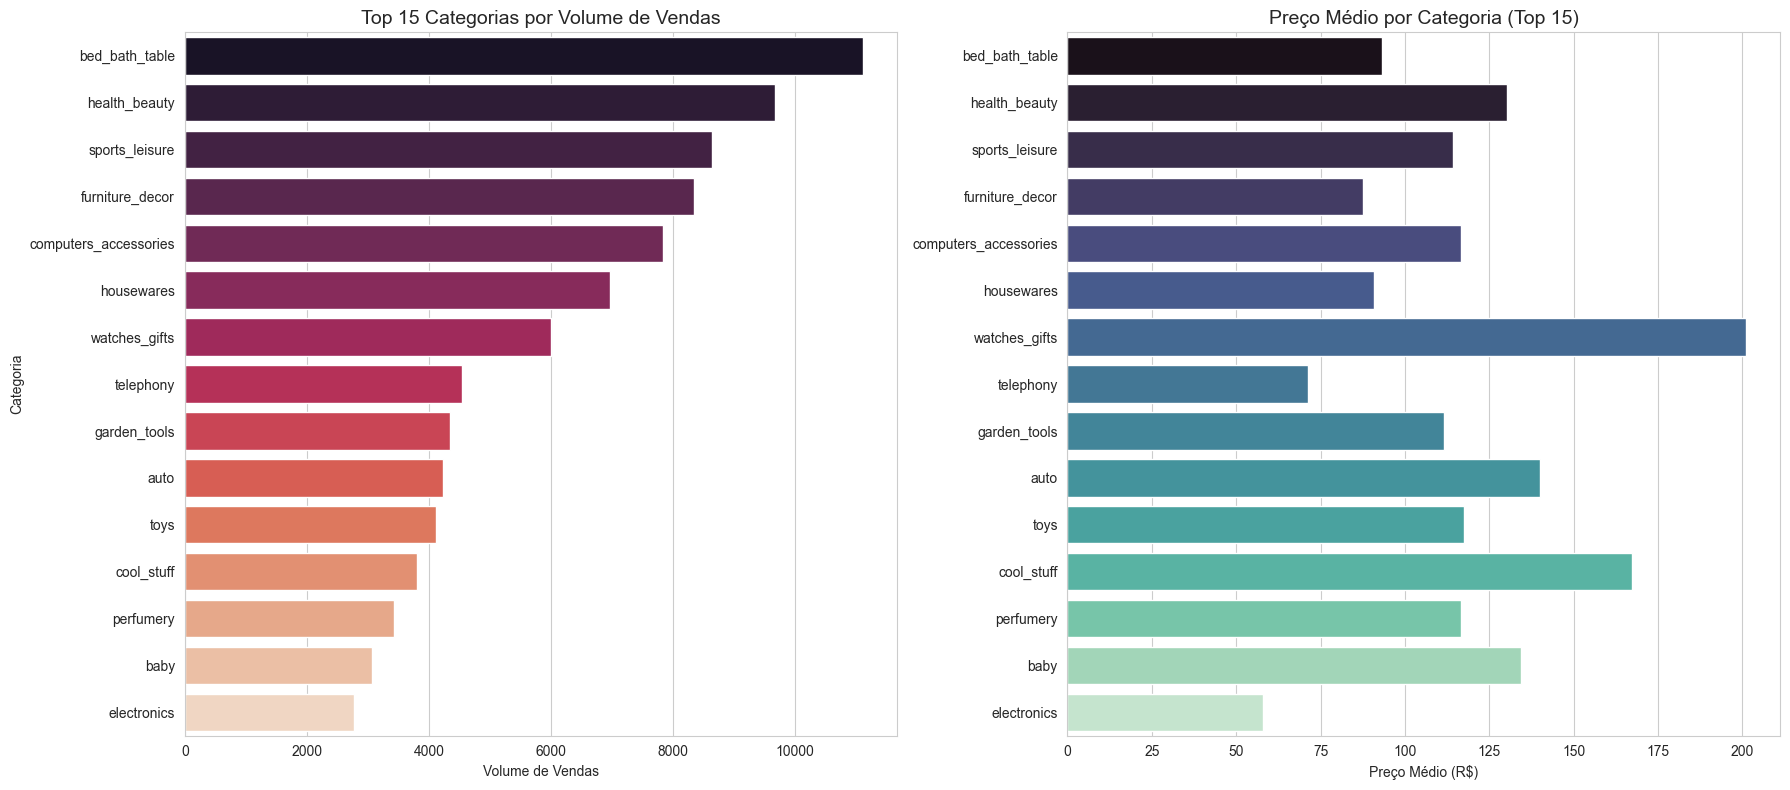

Insights: Estes gráficos permitem comparar o volume de vendas e o preço médio entre as categorias. Você pode identificar categorias que vendem muito a preços baixos (ex: eletrônicos) e outras que vendem menos, mas têm um preço médio alto (ex: móveis).


In [36]:
#import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Requisitando dados das novas tabelas
print("🔌 Conectando ao Snowflake para carregar products e product_category_translation...")
conn = snowflake.connector.connect(
    user=SF_USER,
    password=SF_PASSWORD,
    account=SF_ACCOUNT,
    warehouse=SF_WAREHOUSE,
    database=SF_DATABASE,
    schema=SF_SCHEMA
)
# --- Unindo as tabelas para a análise ---
# Primeiro, unimos as categorias de produto em português e inglês
df_products_with_trans = df_products.merge(
    df_product_cat_trans,
    on='product_category_name',
    how='left'
)

# Em seguida, juntamos com os dados de vendas (df_order_items)
df_sales_by_category = df_order_items.merge(
    df_products_with_trans[['product_id', 'product_category_name_english']],
    on='product_id',
    how='left'
)

# --- CORREÇÃO: Conversão da coluna 'price' para numérico ---
df_sales_by_category['price'] = pd.to_numeric(df_sales_by_category['price'], errors='coerce')

# --- Calculando e Visualizando ---
# Remove nulos nas categorias traduzidas
df_sales_by_category.dropna(subset=['product_category_name_english'], inplace=True)

# Calcula o volume de vendas e o preço médio por categoria
category_summary = df_sales_by_category.groupby('product_category_name_english').agg(
    volume_vendas=('order_item_id', 'count'),
    preco_medio=('price', 'mean')
).sort_values(by='volume_vendas', ascending=False)

# Filtra para as top 15 categorias para o gráfico
top_15_categories = category_summary.head(15)

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Gráfico de volume de vendas
sns.barplot(ax=axes[0], y=top_15_categories.index, x=top_15_categories['volume_vendas'], palette='rocket')
axes[0].set_title('Top 15 Categorias por Volume de Vendas', fontsize=14)
axes[0].set_xlabel('Volume de Vendas')
axes[0].set_ylabel('Categoria')

# Gráfico de preço médio
sns.barplot(ax=axes[1], y=top_15_categories.index, x=top_15_categories['preco_medio'], palette='mako')
axes[1].set_title('Preço Médio por Categoria (Top 15)', fontsize=14)
axes[1].set_xlabel('Preço Médio (R$)')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

print("Insights: Estes gráficos permitem comparar o volume de vendas e o preço médio entre as categorias. Você pode identificar categorias que vendem muito a preços baixos (ex: eletrônicos) e outras que vendem menos, mas têm um preço médio alto (ex: móveis).")

C:\Users\pacie\AppData\Local\Temp\ipykernel_23460\1405286795.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='review_score', y='product_volume_cm3', data=df_reviews_products_filtered, palette='viridis')


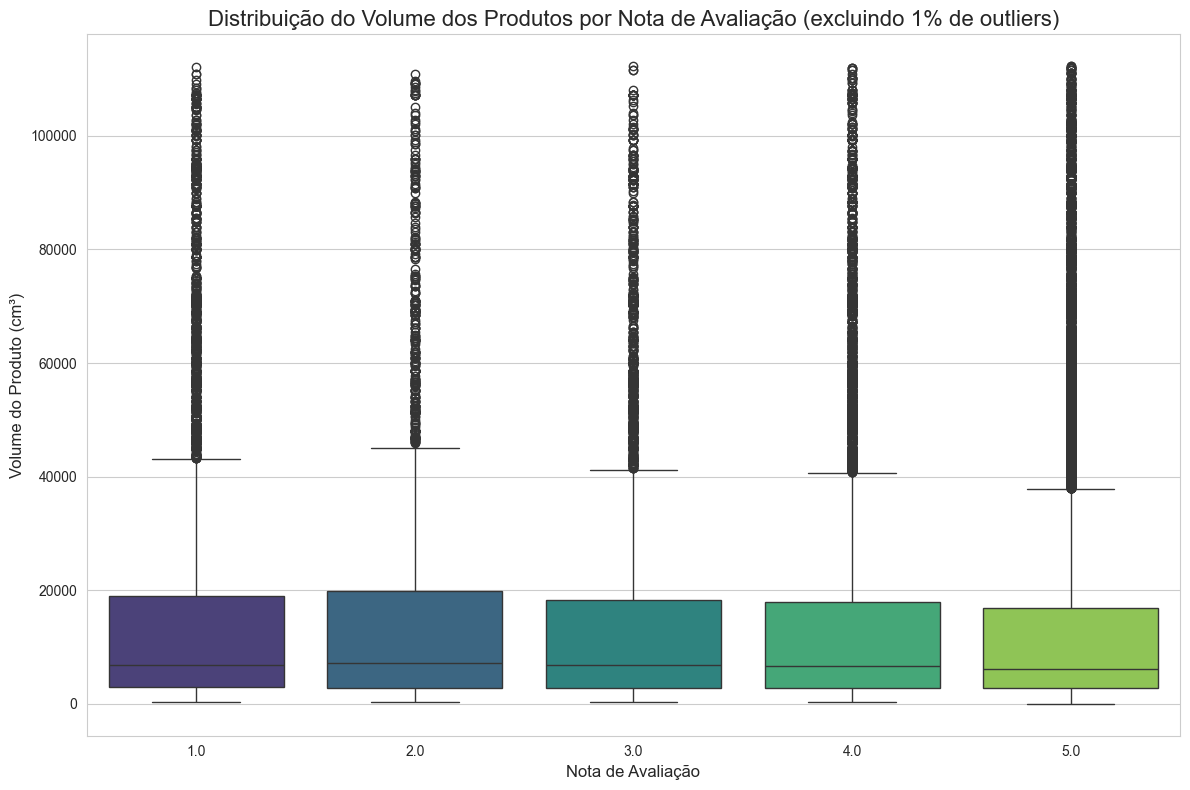

Insights: Este novo gráfico foca na distribuição mais comum dos dados, permitindo uma análise mais precisa. O box plot agora mostra a mediana e a dispersão dos volumes para cada nota de avaliação. Se a caixa para a nota 1, por exemplo, estiver posicionada de forma significativamente diferente da caixa para a nota 5, isso pode indicar uma relação entre o volume do produto e a satisfação do cliente.


In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Unindo os dados de reviews com os dados dos produtos
df_reviews_products = df_orders_reviews.merge(
    df_order_items[['order_id', 'product_id']],
    on='order_id',
    how='left'
)

# Unindo os dados de volume dos produtos
df_reviews_products = df_reviews_products.merge(
    df_products[['product_id', 'product_volume_cm3']],
    on='product_id',
    how='left'
)

# --- Limpeza e Visualização CORRIGIDA ---

# 💡 A correção está aqui: Converte a coluna 'product_volume_cm3' para numérico
df_reviews_products['product_volume_cm3'] = pd.to_numeric(df_reviews_products['product_volume_cm3'], errors='coerce')
df_reviews_products['review_score'] = pd.to_numeric(df_reviews_products['review_score'], errors='coerce')
df_reviews_products.dropna(subset=['review_score', 'product_volume_cm3'], inplace=True)


# 💡 Melhoria: Filtra os outliers extremos na coluna 'product_volume_cm3'
# Vamos manter apenas 99% dos dados com o menor volume
volume_threshold = df_reviews_products['product_volume_cm3'].quantile(0.99)
df_reviews_products_filtered = df_reviews_products[df_reviews_products['product_volume_cm3'] <= volume_threshold]

plt.figure(figsize=(12, 8))
sns.boxplot(x='review_score', y='product_volume_cm3', data=df_reviews_products_filtered, palette='viridis')
plt.title('Distribuição do Volume dos Produtos por Nota de Avaliação (excluindo 1% de outliers)', fontsize=16)
plt.xlabel('Nota de Avaliação', fontsize=12)
plt.ylabel('Volume do Produto (cm³)', fontsize=12)
plt.tight_layout()
plt.show()

print("Insights: Este novo gráfico foca na distribuição mais comum dos dados, permitindo uma análise mais precisa. O box plot agora mostra a mediana e a dispersão dos volumes para cada nota de avaliação. Se a caixa para a nota 1, por exemplo, estiver posicionada de forma significativamente diferente da caixa para a nota 5, isso pode indicar uma relação entre o volume do produto e a satisfação do cliente.")

### 1. Análise de Frequência de Pagamentos Parcelados por Estado
Esta análise vai responder à pergunta: "Existe alguma diferença regional no uso de pagamentos parcelados?". Cruzando as tabelas de orders, customers e order_payments, podemos visualizar como o número de parcelas varia entre os estados.

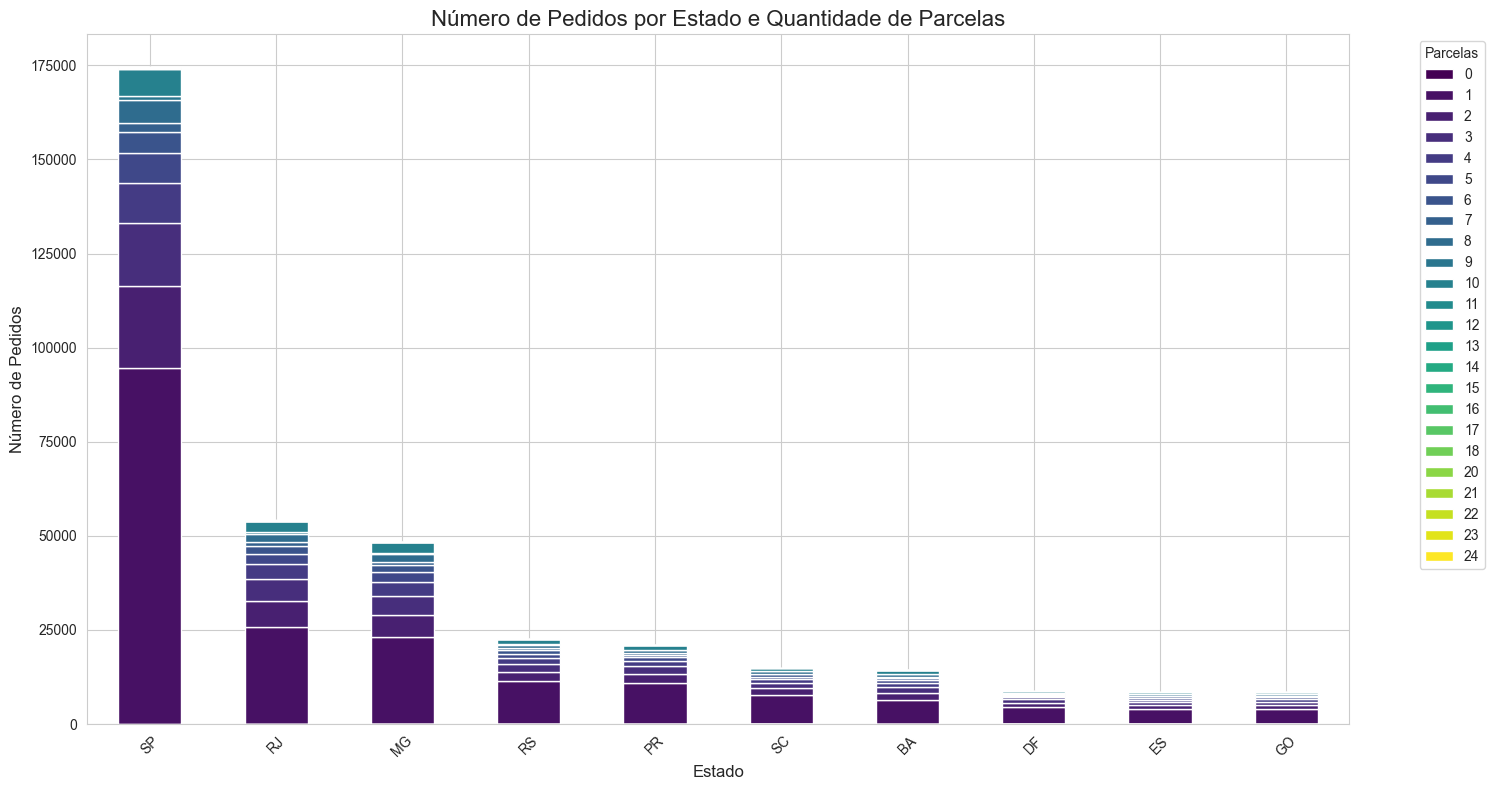

Insights: Este gráfico pode revelar tendências de compra regionais. Você pode notar que alguns estados preferem parcelamentos mais longos, enquanto outros concentram a maioria de seus pagamentos em 1 ou 2 parcelas.


In [54]:
#import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configuração visual
sns.set_style("whitegrid")

# Unindo os dados
df_payments_customers = df_payments.merge(
    df_orders_customers[['order_id', 'customer_state']],
    on='order_id',
    how='left'
)

# Limpeza e preparação dos dados
df_payments_customers['payment_installments'] = pd.to_numeric(
    df_payments_customers['payment_installments'], errors='coerce'
).fillna(0).astype(int)

# Contagem de pedidos por estado e número de parcelas
installments_by_state = df_payments_customers.groupby(['customer_state', 'payment_installments']).size().reset_index(name='count')

# Pivotando a tabela para visualização
pivot_installments = installments_by_state.pivot(
    index='customer_state',
    columns='payment_installments',
    values='count'
).fillna(0)

# Filtra para os 10 estados com mais pedidos
top_10_states = df_orders_customers['customer_state'].value_counts().nlargest(10).index
pivot_installments = pivot_installments.loc[top_10_states]

# Plota o gráfico de barras empilhadas
pivot_installments.plot(kind='bar', stacked=True, figsize=(15, 8), colormap='viridis')
plt.title('Número de Pedidos por Estado e Quantidade de Parcelas', fontsize=16)
plt.xlabel('Estado', fontsize=12)
plt.ylabel('Número de Pedidos', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Parcelas', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

print("Insights: Este gráfico pode revelar tendências de compra regionais. Você pode notar que alguns estados preferem parcelamentos mais longos, enquanto outros concentram a maioria de seus pagamentos em 1 ou 2 parcelas.")

### 2. Análise de Avaliação Média por Categoria de Produto
Este código junta as informações de orders_reviews, order_items e as tabelas de products para calcular a nota de avaliação média para cada categoria. O gráfico resultante será um bar plot, que é mais fácil de interpretar do que um gráfico de linha em casos de relações complexas.

C:\Users\pacie\AppData\Local\Temp\ipykernel_23460\3981307770.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


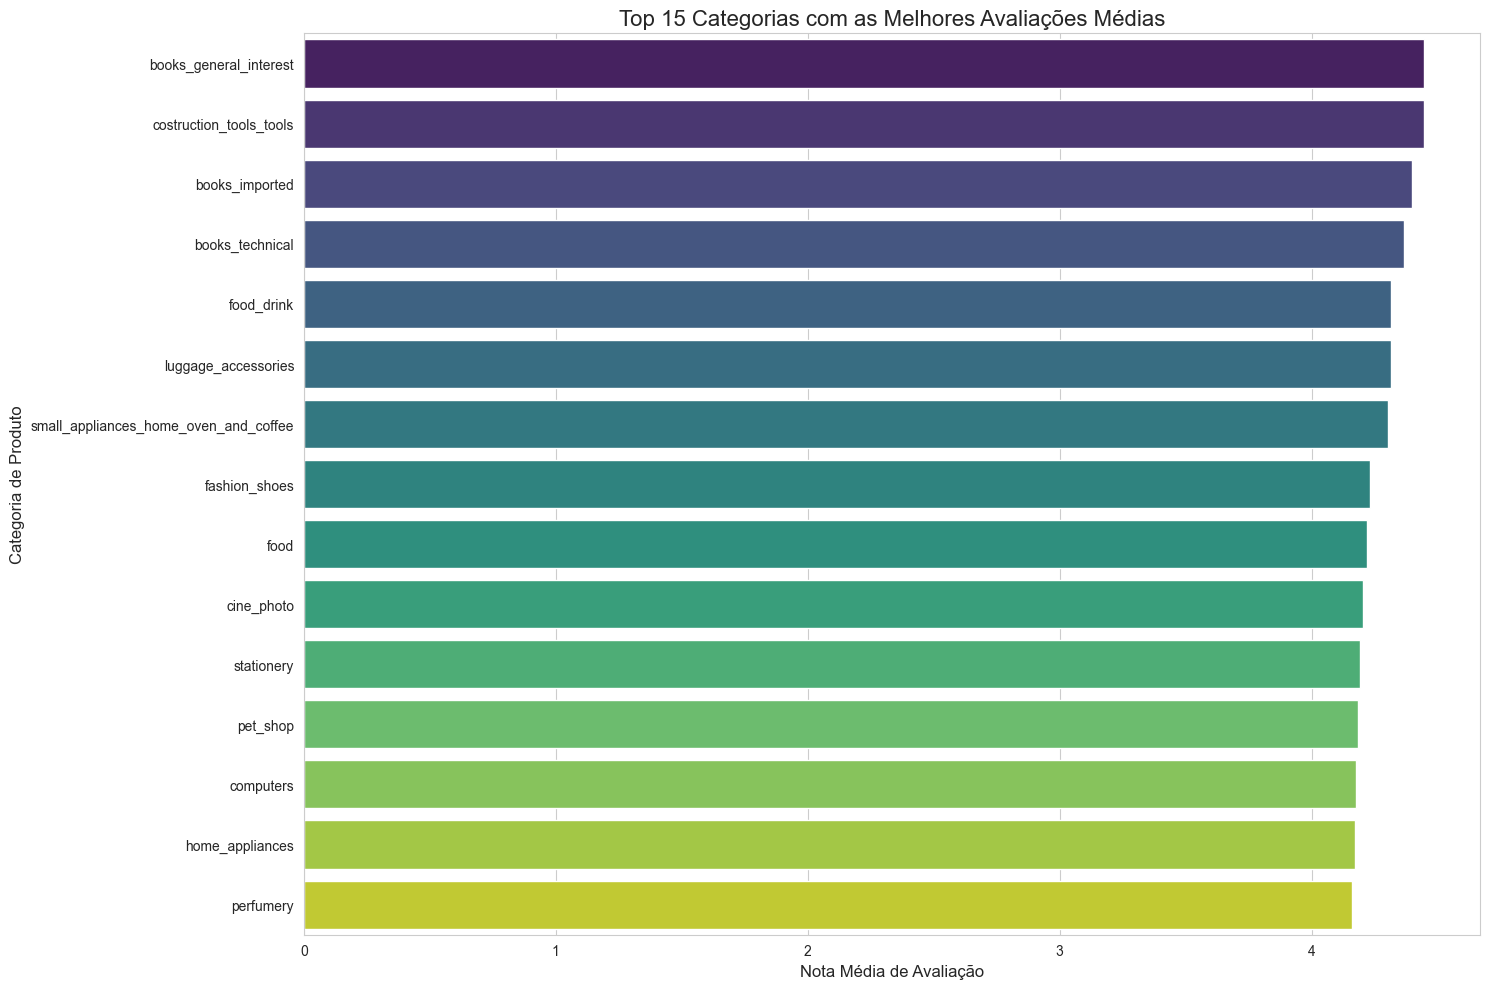

C:\Users\pacie\AppData\Local\Temp\ipykernel_23460\3981307770.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


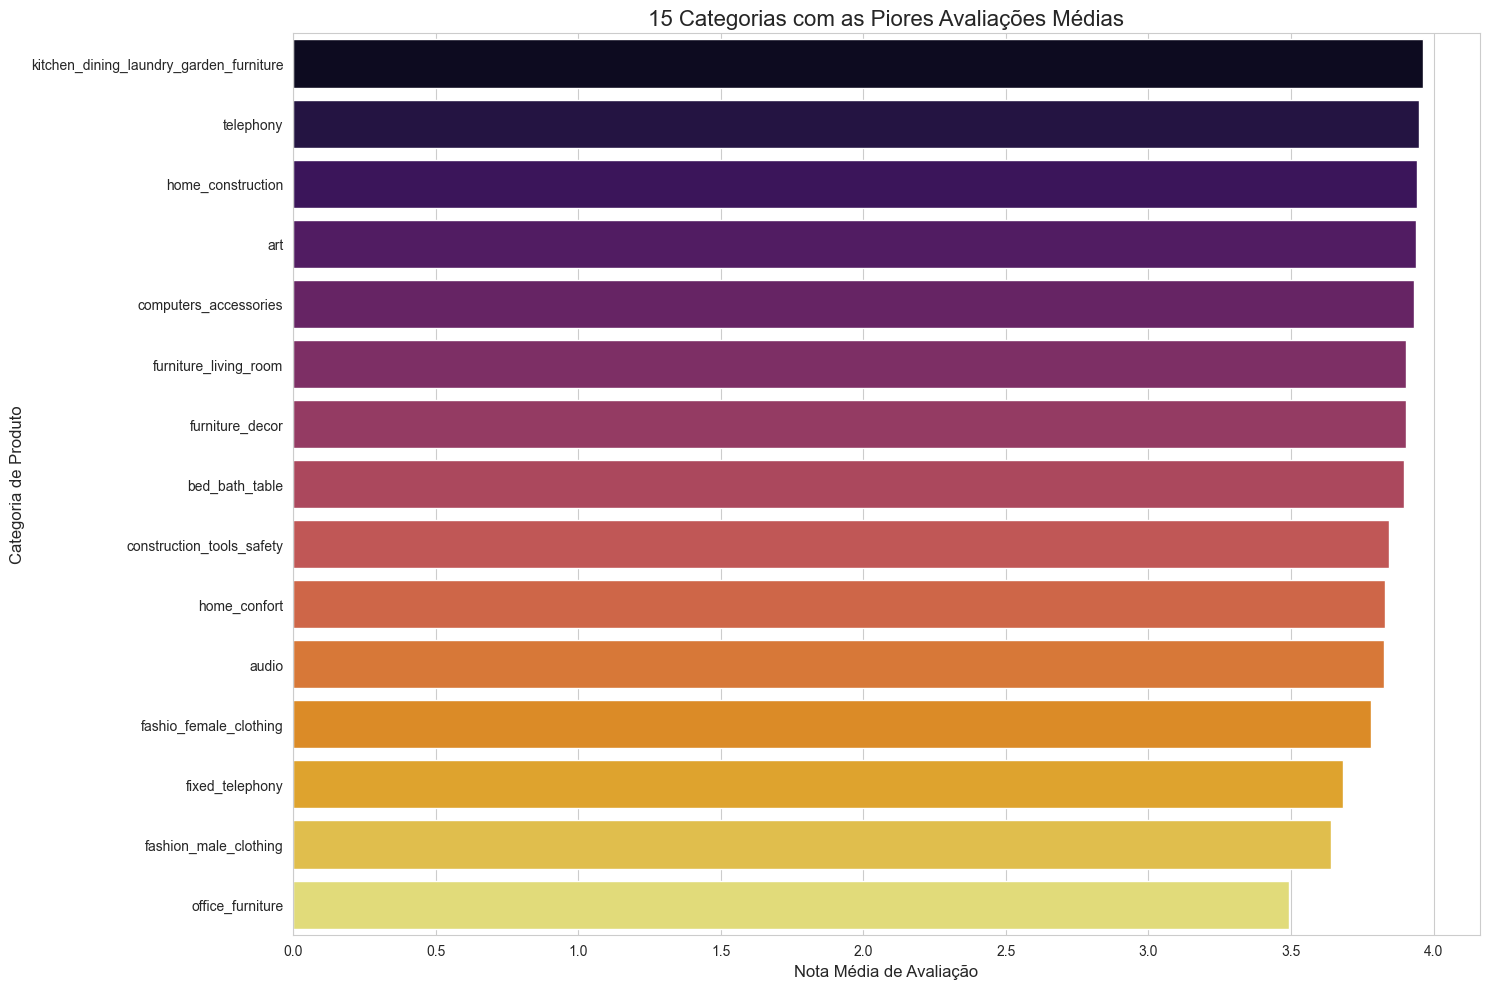

Insights: Estes gráficos revelam diretamente quais categorias estão gerando mais satisfação e quais precisam de atenção. Você pode identificar categorias com notas consistentemente baixas, o que pode indicar problemas com a qualidade do produto, descrição, ou logística de entrega específica para esses itens.


In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Unindo as tabelas para a análise de avaliações por categoria ---
# Assume que df_orders_reviews, df_order_items, df_products e df_product_cat_trans já estão carregados.

# 1. Junta avaliações com itens de pedido para ligar a nota ao produto
df_reviews_with_products = df_orders_reviews.merge(
    df_order_items[['order_id', 'product_id']],
    on='order_id',
    how='left'
)

# 2. Junta com a tabela de produtos para obter a categoria
df_reviews_with_categories = df_reviews_with_products.merge(
    df_products[['product_id', 'product_category_name']],
    on='product_id',
    how='left'
)

# 3. Junta com a tabela de tradução para ter nomes em inglês
df_reviews_with_categories = df_reviews_with_categories.merge(
    df_product_cat_trans,
    on='product_category_name',
    how='left'
)

# --- Limpeza e Agregação ---
df_reviews_with_categories['review_score'] = pd.to_numeric(
    df_reviews_with_categories['review_score'], errors='coerce'
)

# Remove valores nulos nas colunas principais para a análise
df_reviews_with_categories.dropna(
    subset=['product_category_name_english', 'review_score'],
    inplace=True
)

# Calcula a nota média por categoria
category_scores = df_reviews_with_categories.groupby(
    'product_category_name_english'
).agg(
    nota_media=('review_score', 'mean'),
    total_reviews=('review_score', 'count')
).reset_index()

# Filtra categorias com menos de 50 avaliações para evitar notas não representativas
category_scores_filtered = category_scores[category_scores['total_reviews'] >= 50]

# Ordena os resultados pela nota média
category_scores_filtered = category_scores_filtered.sort_values(by='nota_media', ascending=False)

# --- Visualização ---
plt.figure(figsize=(15, 10))
sns.barplot(
    x='nota_media',
    y='product_category_name_english',
    data=category_scores_filtered.head(15), # Top 15 melhores avaliadas
    palette='viridis'
)
plt.title('Top 15 Categorias com as Melhores Avaliações Médias', fontsize=16)
plt.xlabel('Nota Média de Avaliação', fontsize=12)
plt.ylabel('Categoria de Produto', fontsize=12)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 10))
sns.barplot(
    x='nota_media',
    y='product_category_name_english',
    data=category_scores_filtered.tail(15), # 15 piores avaliadas
    palette='inferno'
)
plt.title('15 Categorias com as Piores Avaliações Médias', fontsize=16)
plt.xlabel('Nota Média de Avaliação', fontsize=12)
plt.ylabel('Categoria de Produto', fontsize=12)
plt.tight_layout()
plt.show()

print("Insights: Estes gráficos revelam diretamente quais categorias estão gerando mais satisfação e quais precisam de atenção. Você pode identificar categorias com notas consistentemente baixas, o que pode indicar problemas com a qualidade do produto, descrição, ou logística de entrega específica para esses itens.")

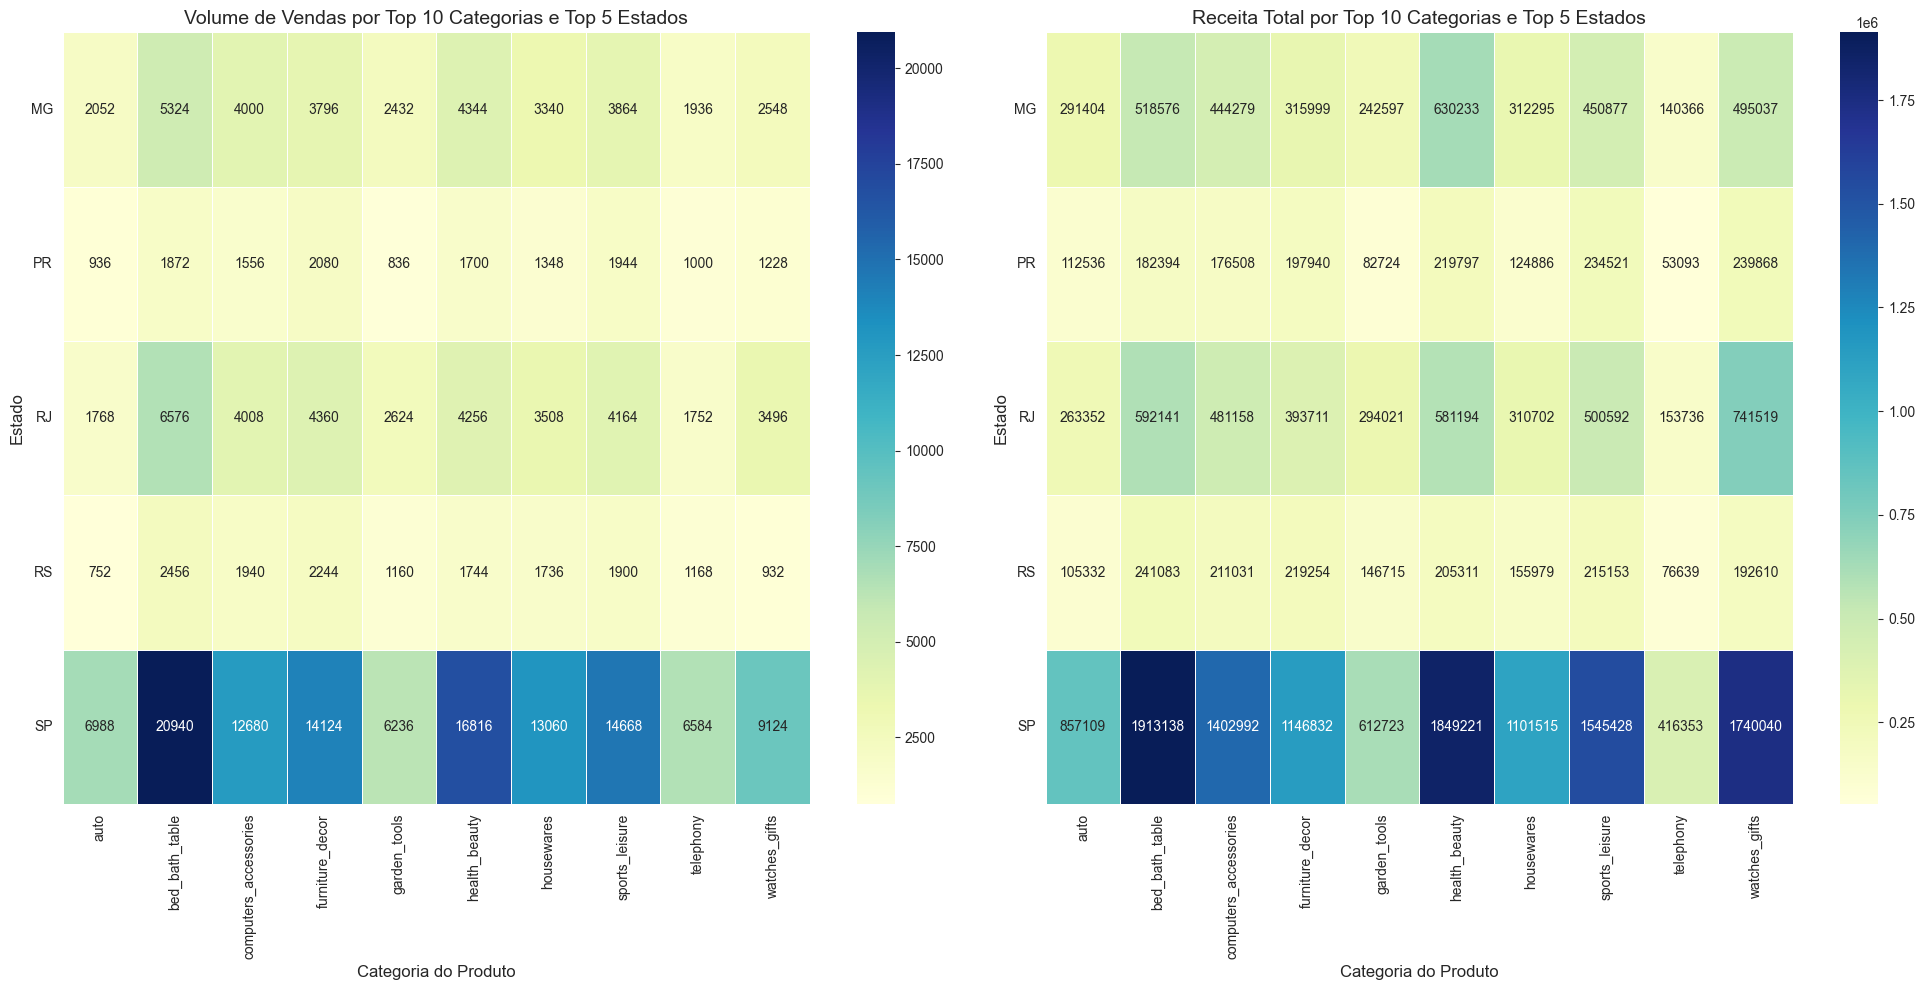

Insights: Estes novos heatmaps são mais focados e mais fáceis de ler. Agora, você pode identificar com clareza quais são as categorias mais populares e lucrativas em cada um dos principais mercados, sem a distração das categorias de nicho.


In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configuração visual
sns.set_style("whitegrid")

# Assumimos que o DataFrame df_sales_locations já foi criado na célula anterior
# com todas as junções necessárias

# --- Limpeza e preparação dos dados ---
df_sales_locations['price'] = pd.to_numeric(df_sales_locations['price'], errors='coerce')
df_sales_locations.dropna(subset=['customer_state', 'product_category_name_english', 'price'], inplace=True)

# 💡 MELHORIA: Identificando as TOP 10 categorias mais populares
top_10_categories = df_sales_locations['product_category_name_english'].value_counts().nlargest(10).index
df_filtered = df_sales_locations[
    df_sales_locations['product_category_name_english'].isin(top_10_categories)
]

# Identificando os top 5 estados para focar a análise
top_5_states = df_filtered['customer_state'].value_counts().nlargest(5).index
df_filtered = df_filtered[
    df_filtered['customer_state'].isin(top_5_states)
]

# --- Agregação para o heatmap ---
# Calcula o volume de vendas por estado e categoria
sales_volume = df_filtered.groupby(
    ['customer_state', 'product_category_name_english']
).size().unstack(fill_value=0)

# Calcula a receita total por estado e categoria
total_revenue = df_filtered.groupby(
    ['customer_state', 'product_category_name_english']
)['price'].sum().unstack(fill_value=0)

# --- Visualização em Heatmap ---
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Heatmap de Volume de Vendas
sns.heatmap(sales_volume, ax=axes[0], cmap='YlGnBu', annot=True, fmt='d', linewidths=.5)
axes[0].set_title('Volume de Vendas por Top 10 Categorias e Top 5 Estados', fontsize=14)
axes[0].set_xlabel('Categoria do Produto', fontsize=12)
axes[0].set_ylabel('Estado', fontsize=12)
axes[0].tick_params(axis='x', rotation=90)
axes[0].tick_params(axis='y', rotation=0)

# Heatmap de Receita Total
sns.heatmap(total_revenue, ax=axes[1], cmap='YlGnBu', annot=True, fmt='.0f', linewidths=.5)
axes[1].set_title('Receita Total por Top 10 Categorias e Top 5 Estados', fontsize=14)
axes[1].set_xlabel('Categoria do Produto', fontsize=12)
axes[1].set_ylabel('Estado', fontsize=12)
axes[1].tick_params(axis='x', rotation=90)
axes[1].tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.show()

print("Insights: Estes novos heatmaps são mais focados e mais fáceis de ler. Agora, você pode identificar com clareza quais são as categorias mais populares e lucrativas em cada um dos principais mercados, sem a distração das categorias de nicho.")